In [69]:
import pandas as pd
import xgboost as xgb
from numpy import ravel
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import scale
%matplotlib inline

# Reading data and removing N/As

In [8]:
data = pd.read_csv('data.csv', index_col='Unnamed: 0')

In [14]:
X = list(data.columns)
X.remove('ID')
X.remove('class')
y = 'class'
data[y] = data[y].map(lambda x: x=='malignant')

In [15]:
for col in X:
    data[col] = data[col].fillna(data[col].mean())

In [16]:
scaler = StandardScaler()
data[X] = scaler.fit_transform(data[X])

In [17]:
data.describe()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9
count,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02
mean,1.071704e+06,2.284772e-16,-2.801765e-16,-5.854481e-16,-1.477121e-16,-1.021199e-15,4.866557e-16,-5.654355e-16,3.874662e-16,7.093356e-16
std,6.170957e+05,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00
min,6.163400e+04,-1.255385e+00,-6.999951e-01,-7.432990e-01,-6.332472e-01,-1.001495e+00,-7.069914e-01,-1.024981e+00,-6.118250e-01,-3.439118e-01
25%,8.706885e+05,-8.889541e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-7.069914e-01,-6.018004e-01,-6.118250e-01,-3.439118e-01
50%,1.171710e+06,-1.560928e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-7.069914e-01,-1.786195e-01,-6.118250e-01,-3.439118e-01
75%,1.238298e+06,2.103378e-01,6.117919e-01,6.035993e-01,4.181537e-01,3.543054e-01,4.043438e-01,2.445615e-01,3.713145e-01,-3.439118e-01
max,1.345435e+07,2.042491e+00,2.251526e+00,2.287222e+00,2.520955e+00,3.065906e+00,1.793513e+00,2.783647e+00,2.337594e+00,4.907421e+00


# Feature correlation plot

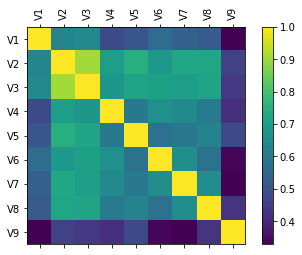

In [137]:
from matplotlib import ticker
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data[X].corr())
fig.colorbar(cax)
alpha = [''] + X
ax.set_xticklabels(alpha, rotation=90)
ax.set_yticklabels(alpha)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Base model (xgb)

In [18]:
train, test = train_test_split(data, train_size=0.8, stratify=data[y], random_state=42)

In [12]:
def evaluateModel(clf):
    clf.fit(train[X], train[y])
    print("Accuracy: %.6g" % metrics.accuracy_score(ravel(test[y]), clf.predict(test[X])))
    print("ROC AUC: %.6g" % metrics.roc_auc_score(ravel(test[y]), clf.predict_proba(test[X])[:,1]))
    print("Log loss: %.6g" % metrics.log_loss(ravel(test[y]), clf.predict_proba(test[X])[:,1]))

In [140]:
evaluateModel(XGBClassifier(seed=42, nthread=4))

Accuracy: 0.942857
ROC AUC: 0.988678
Log loss: 0.145189


# Tune xgb params

In [71]:
param_test1 = {
 'n_estimators':range(10, 23, 1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, nthread=4, seed=42,),
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[X], ravel(train[y]))
print(gsearch1.best_params_, gsearch1.best_score_)
n_estimators = gsearch1.best_params_['n_estimators']

{'n_estimators': 22} 0.991514663685


In [73]:
param_test2 = {
 'max_depth':[2,3,4,5],
 'min_child_weight':[1,2,3,4,5,6,7,8]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, 
                                                 n_estimators=n_estimators,
                                                 nthread=4,
                                                 seed=42), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[X], ravel(train[y]))
gsearch2.best_params_, gsearch2.best_score_
#{'max_depth': 3, 'min_child_weight': 1} it's default values for xgb

({'max_depth': 3, 'min_child_weight': 1}, 0.99151466368481511)

In [77]:
param_test3 = {
 'gamma':[i/1000.0 for i in range(0,100)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.3,
                                                  n_estimators=n_estimators,
                                                  nthread=4,
                                                  seed=42),
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[X], ravel(train[y]))
gamma = gsearch3.best_params_['gamma']
print(gsearch3.best_params_, gsearch3.best_score_)

{'gamma': 0.008} 0.991653263823


In [76]:
param_test4 = {
 'subsample':[i/100.0 for i in range(90,101,1)],
 'colsample_bytree':[i/100.0 for i in range(90,101,1)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.3,
                                                  n_estimators=n_estimators,
                                                  gamma=gamma,
                                                  nthread=4,
                                                  seed=42),
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[X], ravel(train[y]))
gsearch4.best_params_, gsearch4.best_score_
#{'colsample_bytree': 1.0, 'subsample': 1.0} it's default values for xgb

({'colsample_bytree': 1.0, 'subsample': 1.0}, 0.99165326382341523)

In [78]:
param_test5 = {
 'reg_alpha':[0, 0.00001, 0.00005, 0.0001],
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.3,
                                                  n_estimators=n_estimators,
                                                  gamma=gamma,
                                                  nthread=4,
                                                  seed=42),
    param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[X], ravel(train[y]))
print(gsearch5.best_params_, gsearch5.best_score_)

{'reg_alpha': 0} 0.991653263823


In [141]:
evaluateModel(XGBClassifier(learning_rate = 0.3,
                              n_estimators=n_estimators,
                              gamma=gamma,
                              nthread=4,
                              seed=42))

Accuracy: 0.957143
ROC AUC: 0.990716
Log loss: 0.127106


# Random forest

In [83]:
evaluateModel(RandomForestClassifier(n_estimators=31, random_state=42, n_jobs=4))

Accuracy: 0.957143
ROC AUC: 0.979506
Log loss: 0.349592


# Tune rf params

In [85]:
param_test1 = {
     'n_estimators':range(20, 40, 1)
}
gsearch = GridSearchCV(estimator = RandomForestClassifier(n_jobs=4, random_state=42),
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch.fit(train[X], ravel(train[y]))
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 31}, 0.99213084472637481)

In [142]:
evaluateModel(RandomForestClassifier(n_estimators=32, n_jobs=4, random_state=42))

Accuracy: 0.957143
ROC AUC: 0.97928
Log loss: 0.350058


# ExtraTreesClassifier

In [88]:
evaluateModel(ExtraTreesClassifier(n_jobs=4, random_state=42))

Accuracy: 0.928571
ROC AUC: 0.977355
Log loss: 0.366092


# Tune et params

In [91]:
param_test1 = {
     'n_estimators':range(30, 51, 1)
}
gsearch = GridSearchCV(estimator = ExtraTreesClassifier(n_jobs=4, random_state=42),
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, iid=False, cv=5)
gsearch.fit(train[X], ravel(train[y]))
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 43}, 0.99445122289390486)

In [143]:
evaluateModel(ExtraTreesClassifier(n_estimators=43, n_jobs=4, random_state=42))

Accuracy: 0.957143
ROC AUC: 0.990489
Log loss: 0.116324


# KNN

In [144]:
evaluateModel(KNeighborsClassifier(n_jobs=4))

Accuracy: 0.942857
ROC AUC: 0.972826
Log loss: 0.80515


# LR

In [204]:
evaluateModel(LogisticRegressionCV(n_jobs=4, random_state=42))

Accuracy: 0.942857
ROC AUC: 0.995018
Log loss: 0.103995


# SVC

In [61]:
param_test4 = {
 'C':[0.001, 0.01, 0.1, 1, 10, 100],
 'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
 'gamma':[0.001, 0.0001]
}
gsearch4 = GridSearchCV(estimator = SVC(random_state=42, probability=True),
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[X], ravel(train[y]))
print(gsearch4.best_params_, gsearch4.best_score_)

{'C': 0.01, 'kernel': 'linear', 'gamma': 0.001} 0.99467583606


In [62]:
evaluateModel(SVC(C=0.01, kernel='linear', gamma=0.001, random_state=42, probability=True))

Accuracy: 0.964286
ROC AUC: 0.993659
Log loss: 0.105842


# MLP

In [229]:
evaluateModel(MLPClassifier(hidden_layer_sizes=(41), random_state=42, max_iter=500))

Accuracy: 0.957143
ROC AUC: 0.994339
Log loss: 0.101094


# Ensembling

In [76]:
clfs = [
    LogisticRegressionCV(cv=10, n_jobs=4,scoring='log_loss', max_iter=200, random_state=42),
    MLPClassifier(hidden_layer_sizes=(41,), random_state=42, max_iter=500),
    #SVC(C=0.01, kernel='linear', gamma=0.001, random_state=42, probability=True)
]

In [77]:
train_a, train_b = train_test_split(train, stratify=train[y], random_state=42, train_size=0.7)

In [78]:
X_lr_train = np.zeros((train_b.shape[0], len(clfs)))
X_lr_test = np.zeros((test.shape[0], len(clfs)))

In [79]:
for i, clf in enumerate(clfs):
    clf.fit(train_a[X], ravel(train_a[y]))
    X_lr_train[:,i] = clf.predict_proba(train_b[X])[:,1]
    X_lr_test[:,i] = clf.predict_proba(test[X])[:,1]
    print("on test AUC_ROC: {1}".format(i, metrics.roc_auc_score(ravel(test[y]), X_lr_test[:,i])))
    print("on test Log_loss: {1}".format(i, metrics.log_loss(ravel(test[y]), X_lr_test[:,i])))

on test AUC_ROC: 0.994338768115942
on test Log_loss: 0.10636927585827866
on test AUC_ROC: 0.9938858695652174
on test Log_loss: 0.10474300490152359


In [80]:
#The best one
y_proba = np.mean(X_lr_test, axis=1)
y_pred = list(map(lambda x: x>0.5, y_proba))
print("Accuracy: %.6g" % metrics.accuracy_score(ravel(test[y]), y_pred))
print("ROC AUC: %.6g" % metrics.roc_auc_score(ravel(test[y]), y_proba))
print("Log los: %.6g" % metrics.log_loss(ravel(test[y]), y_proba))

Accuracy: 0.964286
ROC AUC: 0.994112
Log los: 0.104309


In [70]:
#for some reason simple bagging works better than stacking
lr = LogisticRegressionCV(cv=10,n_jobs=4,scoring='log_loss', max_iter=100)
lr.fit(scale(X_lr_train), train_b[y])
print("Accuracy: %.6g" % metrics.accuracy_score(ravel(test[y]), lr.predict(X_lr_test)))
print("ROC AUC: %.6g" % metrics.roc_auc_score(ravel(test[y]), lr.predict_proba(X_lr_test)[:,1]))
print("Log loss: %.6g" % metrics.log_loss(ravel(test[y]), lr.predict_proba(X_lr_test)[:,1]))

Accuracy: 0.785714
ROC AUC: 0.97577
Log loss: 0.443885
